In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
from matplotlib import pyplot as plt
import gseapy as gp
from scipy import stats
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
adata = sc.read_h5ad('../Data/TSC_scRNAseq/FLC_TSC_scRNAseq.h5ad')

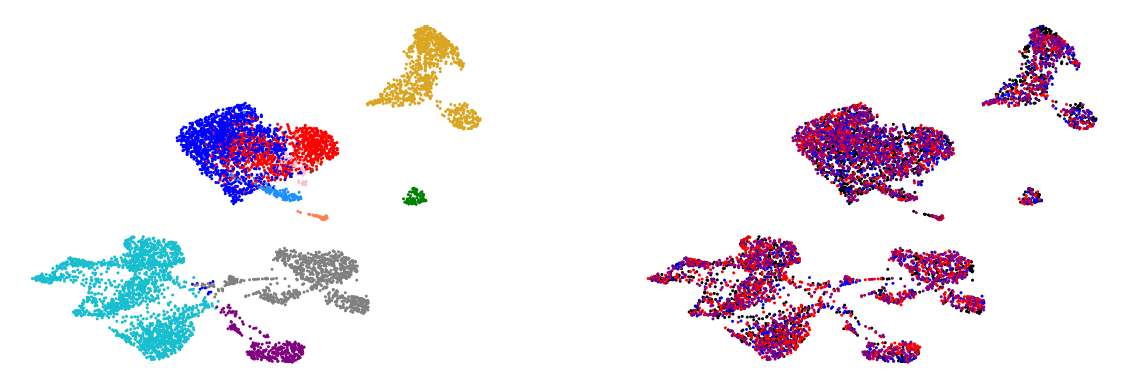

In [3]:
palette_dict={
    'B cells':'coral',
    'CD4 T cell':'Blue',
    'CD8 T cell':'Red',
    'Dendritic cells':'Green',
    'Endothelial':'Purple',
    'Epithelial':'Gray',
    'Fibroblast':'tab:Cyan',
    'Macrophages':'goldenrod',
    'Mast cell':'Brown',
    'NK cell':'Pink',
    'Treg':'Dodgerblue',
    'IgG_AMD3100':'Blue',
    'AMD3100_antiPD1':'Purple',
    'antiPD1':'Red',
    'IgG':'k'
}

sc.pl.umap(adata, color=['Celltype','Condition'],palette=palette_dict,legend_loc=None,frameon=False,title=['',''])


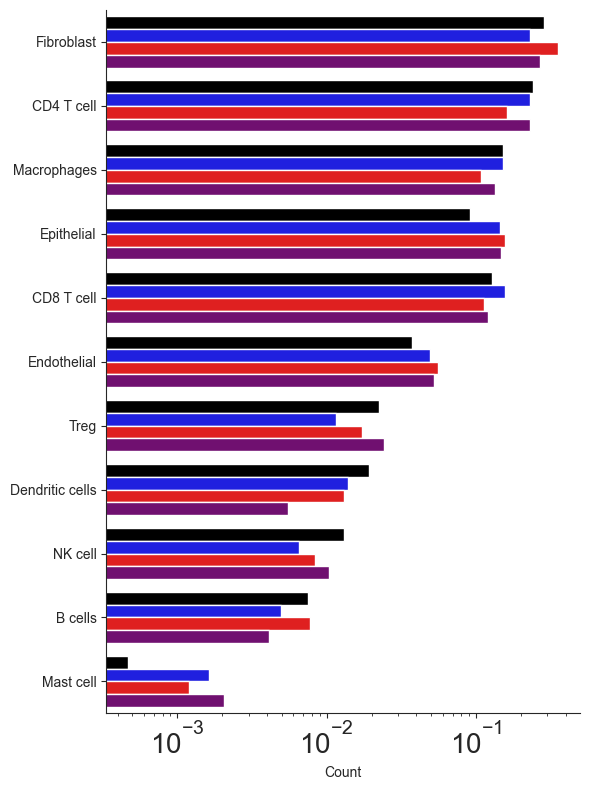

In [4]:
sns.set_style('ticks')
for i,condition in enumerate(adata.obs.Condition.unique()):
    a,b=np.unique(adata[adata.obs.Condition==condition].obs.Celltype,return_counts=1)
    df=pd.DataFrame(np.vstack((a,b/sum(b))).T,columns=['Celltype','Count'])
    df['Condition']=[condition]*df.shape[0]
    if i==0:
        df_all=df
    else:
        df_all=pd.concat((df_all,df))
plt.figure(figsize=(6,8))
sns.barplot(y='Celltype',x='Count',hue='Condition',data=df_all,order=df_all.groupby('Celltype').Count.mean().sort_values()[::-1].index,
           palette=['k','Blue','Red','Purple'])
plt.xscale('log')
plt.legend('',frameon=False)
plt.xticks(fontsize=20)
sns.despine()
plt.ylabel('')
plt.tight_layout()
plt.show()
plt.close()

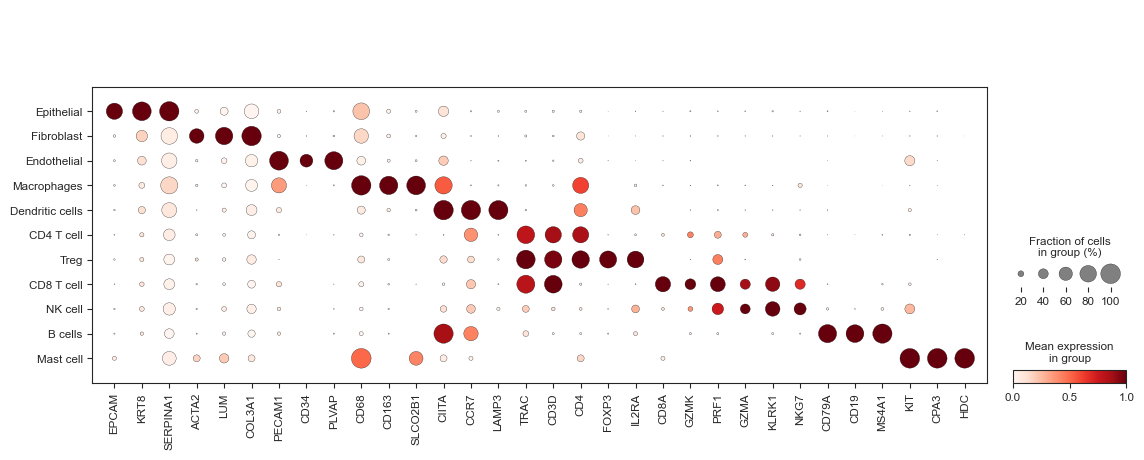

In [5]:
sc.pl.dotplot(adata,groupby='Celltype',var_names=[
    'EPCAM','KRT8','SERPINA1',
    'ACTA2','LUM','COL3A1',
    'PECAM1','CD34','PLVAP',
    'CD68',"CD163",'SLCO2B1',
    'CIITA','CCR7','LAMP3',
    'TRAC','CD3D','CD4',
    'FOXP3','IL2RA',
    'CD8A','GZMK','PRF1',
    'GZMA','KLRK1','NKG7',
    'CD79A','CD19','MS4A1',
    'KIT','CPA3','HDC'],
     standard_scale='var',categories_order=['Epithelial','Fibroblast','Endothelial',
                                           'Macrophages','Dendritic cells','CD4 T cell','Treg','CD8 T cell','NK cell',
                                           'B cells','Mast cell'])

### Figure 7B-C

In [6]:
for x in ['IgG_AMD3100','antiPD1','AMD3100_antiPD1']:
    adata1=adata[adata.obs.Condition.isin(['IgG',x])].copy()
    adata1.obs['stim'] = pd.Categorical(adata1.obs['Condition'], categories=[x,"IgG"], ordered=True)
    indices = adata1.obs.sort_values(['Celltype', 'stim']).index
    adata1 = adata1[indices,:]
    
    bdata = adata1[adata1.obs.Celltype == "CD8 T cell"].copy()
    res = gp.gsea(data=bdata.to_df().T, 
            gene_sets="GO_Biological_Process_2021",
            cls=bdata.obs.stim,
            permutation_num=1000,
            permutation_type='phenotype',
            outdir=None,
            method='s2n', # signal_to_noise
            threads= 16)
    if x=='IgG_AMD3100':
        res_AMD3100=res
    elif x=='antiPD1':
        res_PD1=res
    elif x=='AMD3100_antiPD1':
        res_combo=res

regulation of immune response (GO:0050776)


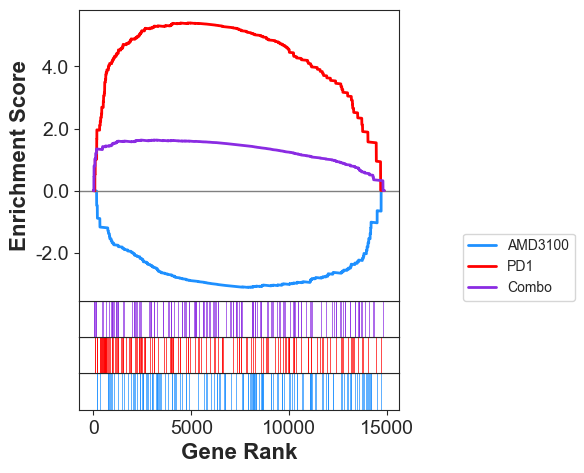

positive regulation of chemotaxis (GO:0050921)


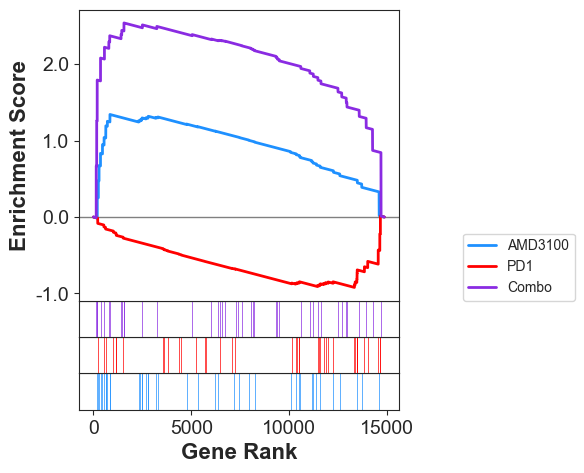

In [7]:
term='regulation of immune response (GO:0050776)'
print(term)
hits = [res_AMD3100.results[term]['hits'],res_PD1.results[term]['hits'],res_combo.results[term]['hits']]
runes = [res_AMD3100.results[term]['RES'],res_PD1.results[term]['RES'],res_combo.results[term]['RES']]
fig = gp.gseaplot2(terms=['AMD3100','PD1','Combo'], RESs=runes, hits=hits, colors=['dodgerblue','Red','blueviolet'],
 legend_kws={'loc': (1.2, 0)},figsize=(4,5)) 
plt.show()
plt.close()

term='positive regulation of chemotaxis (GO:0050921)'
print(term)
hits = [res_AMD3100.results[term]['hits'],res_PD1.results[term]['hits'],res_combo.results[term]['hits']]
runes = [res_AMD3100.results[term]['RES'],res_PD1.results[term]['RES'],res_combo.results[term]['RES']]
fig = gp.gseaplot2(terms=['AMD3100','PD1','Combo'], RESs=runes, hits=hits, colors=['dodgerblue','Red','blueviolet'],
 legend_kws={'loc': (1.2, 0)}, # set the legend loc
               figsize=(4,5)) # rank_metric=pre_res.ranking
plt.show()
plt.close()

### Figure 7D

[None, None, None, None, None, None]

<Figure size 640x480 with 0 Axes>

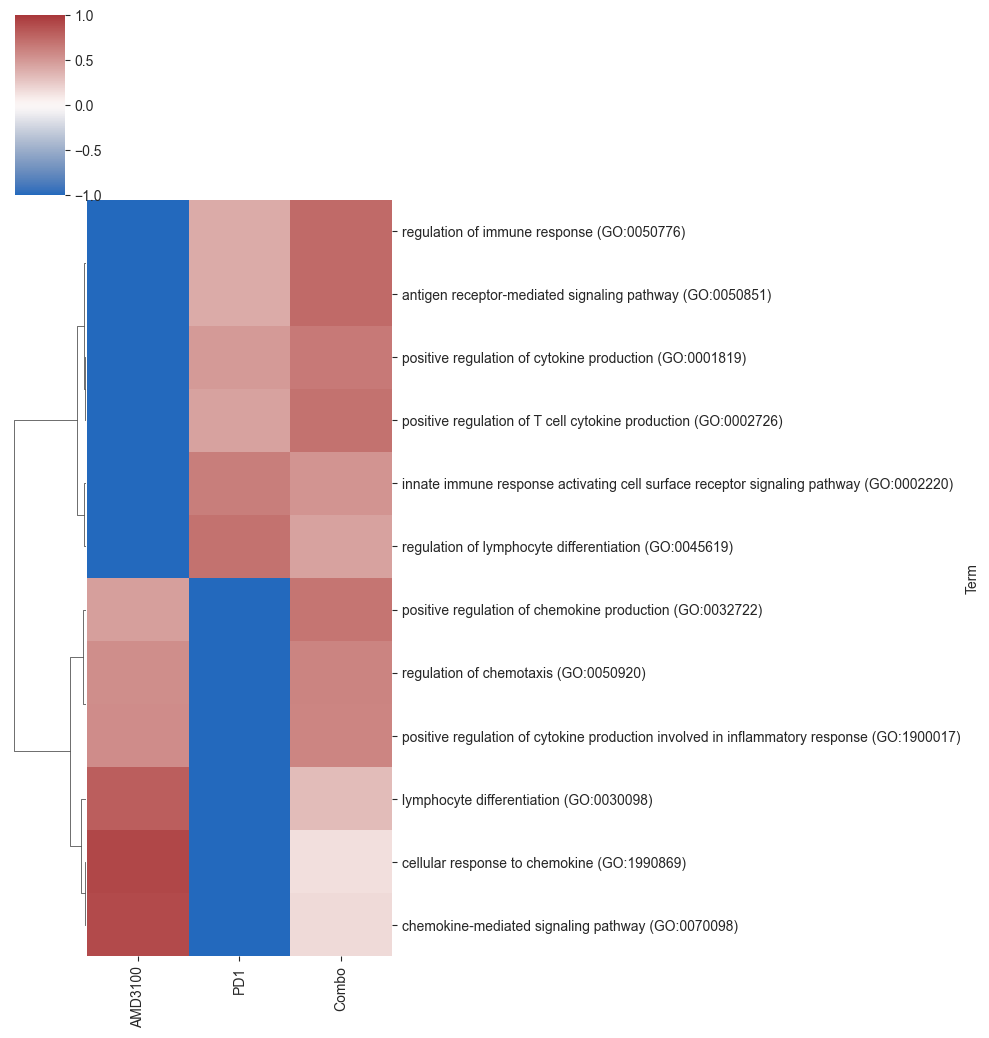

In [8]:
terms=pd.read_csv('../Data/TSC_scRNAseq/Selected GO Terms/CD8_Terms.csv').Term.tolist()
data=[]
for term in terms:
    data.append(np.hstack((term,
                           res_AMD3100.res2d[res_AMD3100.res2d.Term.isin([term])].NES.iloc[0],
                           res_PD1.res2d[res_PD1.res2d.Term.isin([term])].NES.iloc[0],
                           res_combo.res2d[res_combo.res2d.Term.isin([term])].NES.iloc[0])))
data=pd.DataFrame(data,columns=['Term','AMD3100','PD1','Combo'])
data=data.sort_values(by=['Combo'],ascending=0)
data=data.set_index('Term')
data=stats.zscore(data[['AMD3100','PD1','Combo']].astype(float),axis=1)
plt.tight_layout()
ax=sns.clustermap(data.astype(float),center=0,cmap="vlag",z_score=0,vmax=1,vmin=-1,robust=False,col_cluster=False)
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

### Figure 7E

In [9]:
for x in ['IgG_AMD3100','antiPD1','AMD3100_antiPD1']:
    adata1=adata[adata.obs.Condition.isin(['IgG',x])].copy()
    adata1.obs['stim'] = pd.Categorical(adata1.obs['Condition'], categories=[x,"IgG"], ordered=True)
    indices = adata1.obs.sort_values(['Celltype', 'stim']).index
    adata1 = adata1[indices,:]
    
    bdata = adata1[adata1.obs.Celltype.isin(["CD4 T cell","Treg"])].copy()
    res = gp.gsea(data=bdata.to_df().T, 
            gene_sets="GO_Biological_Process_2021",
            cls=bdata.obs.stim,
            permutation_num=1000,
            permutation_type='phenotype',
            outdir=None,
            method='s2n', # signal_to_noise
            threads= 16)
    if x=='IgG_AMD3100':
        res_AMD3100=res
    elif x=='antiPD1':
        res_PD1=res
    elif x=='AMD3100_antiPD1':
        res_combo=res

[None, None, None, None, None, None]

<Figure size 640x480 with 0 Axes>

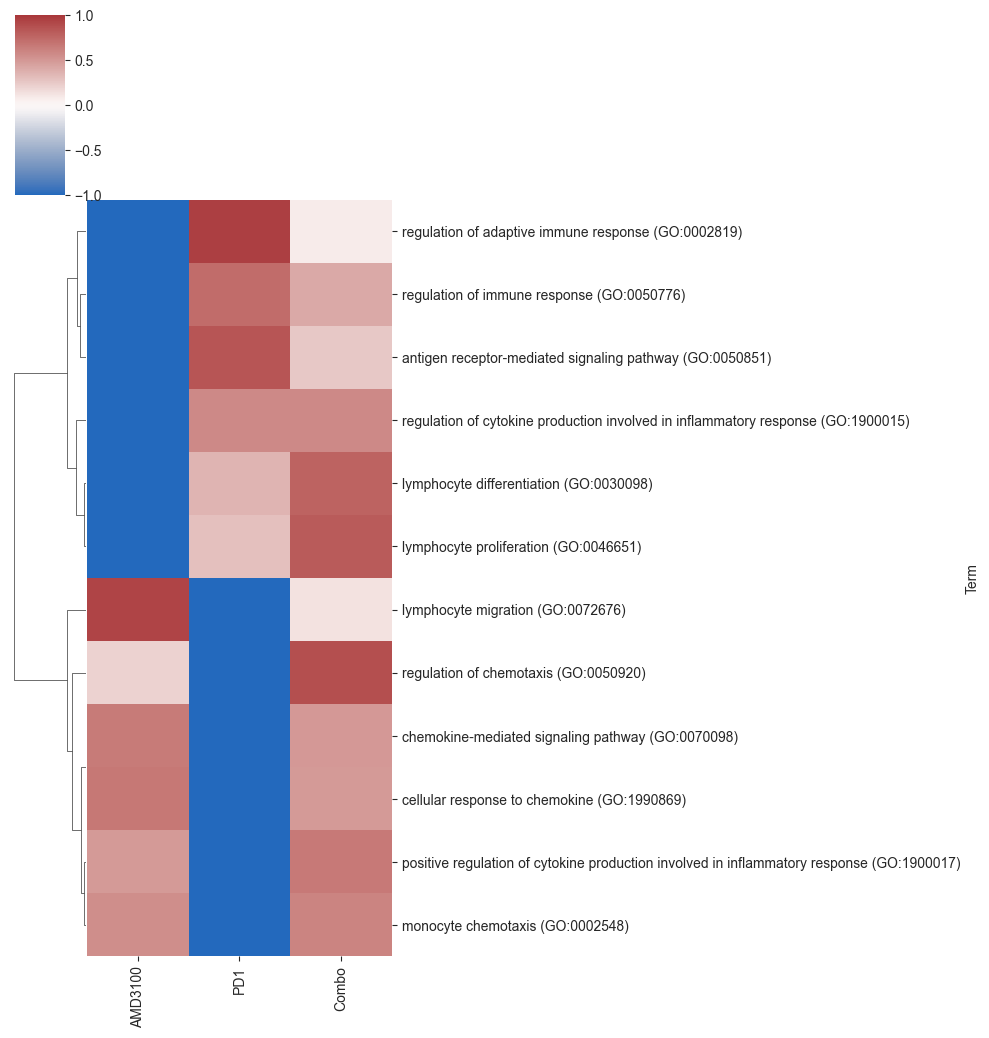

In [10]:
terms=pd.read_csv('../Data/TSC_scRNAseq/Selected GO Terms/CD4_Terms.csv').Term.tolist()
data=[]
for term in terms:
    data.append(np.hstack((term,
                           res_AMD3100.res2d[res_AMD3100.res2d.Term.isin([term])].NES.iloc[0],
                           res_PD1.res2d[res_PD1.res2d.Term.isin([term])].NES.iloc[0],
                           res_combo.res2d[res_combo.res2d.Term.isin([term])].NES.iloc[0])))
data=pd.DataFrame(data,columns=['Term','AMD3100','PD1','Combo'])
data=data.sort_values(by=['Combo'],ascending=0)
data=data.set_index('Term')
data=stats.zscore(data[['AMD3100','PD1','Combo']].astype(float),axis=1)
plt.tight_layout()
ax=sns.clustermap(data.astype(float),center=0,cmap="vlag",z_score=0,vmax=1,vmin=-1,robust=False,col_cluster=False)
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)